##  텍스트 요약(Text Summarization) : Attention 사용

### I - Attention 사용 모델 구현을 위한 데이터 준비하기 : 아마존 리뷰 데이터 'Reviews.csv'

#### 1. 라이브러리 가져오기

#### 2.데이터 가져오기

In [ ]:
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import nltk


In [ ]:
import re
from PIL import Image
from io import BytesIO
from nltk.tokenize import RegexpTokenizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/09.%20Word%20Embedding/dataset/data.csv", filename="data.csv")
df = pd.read_csv("data.csv")
print('전체 문서의 수 :',len(df))

전체 문서의 수 : 2382


In [ ]:

data = pd.read_csv("data.csv", nrows =3000 ) # 56만개중에서 10만개 만 읽어옴
len(data)

2382

In [ ]:
data.head()

,Unnamed: 0.1,Desc,Unnamed: 0,author,genre,image_link,rating,title
0,0,We know that power is shifting: From West to E...,0.0,Moisés Naím,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.63,The End of Power: From Boardrooms to Battlefie...
1,1,Following the success of The Accidental Billio...,1.0,Blake J. Harris,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.94,"Console Wars: Sega, Nintendo, and the Battle t..."
2,2,How to tap the power of social software and ne...,2.0,Chris Brogan,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.78,Trust Agents: Using the Web to Build Influence...
3,3,William J. Bernstein is an American financial ...,3.0,William J. Bernstein,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.20,The Four Pillars of Investing
4,4,Amazing book. And I joined Steve Jobs and many...,4.0,Akio Morita,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.05,Made in Japan: Akio Morita and Sony


In [ ]:
import nltk
nltk.download('stopwords')

def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

df['cleaned'] = df['Desc'].apply(_removeNonAscii)
df['cleaned'] = df.cleaned.apply(make_lower_case)
df['cleaned'] = df.cleaned.apply(remove_stop_words)
df['cleaned'] = df.cleaned.apply(remove_punctuation)
df['cleaned'] = df.cleaned.apply(remove_html)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data.sample(10)

,Unnamed: 0.1,Desc,Unnamed: 0,author,genre,image_link,rating,title
2227,2296,Winner of the 2006 Pulitzer Prize for Fiction....,NaN,Geraldine Brooks,Non-Fiction,https://i.gr-assets.com/images/S/compressed.ph...,3.75,March
833,841,From the New York Times bestselling author of ...,842.0,James B. Stewart,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.16,Den of Thieves
849,857,"An economist's version of The Way Things Work,...",858.0,Geoff Smart,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.00,Who: The A Method for Hiring
2138,2207,"In Nick Hornby's How to Be Good, Katie Carr is...",NaN,Nick Hornby,Non-Fiction,https://i.gr-assets.com/images/S/compressed.ph...,3.19,How to Be Good
86,86,In a world inundated with sales books on getti...,86.0,Richard Fenton,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.22,"Go for No! Yes is the Destination, No is How Y..."
1863,1932,"Maybe it was a grandparent, or a teacher or a ...",NaN,Mitch Albom,Non-Fiction,https://i.gr-assets.com/images/S/compressed.ph...,4.10,Tuesdays with Morrie
1054,1062,The Prize recounts the panoramic history of oi...,1063.0,Lawrence Levy,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.28,To Pixar and Beyond: My Unlikely Journey with ...
551,559,"In this stunning new book, Malcolm Gladwell ta...",560.0,Malcolm Gladwell,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.15,Outliers: The Story of Success
1142,1150,How well does your organization respond to cha...,1151.0,Bethany McLean,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.01,All the Devils are Here: The Hidden History of...
1135,1143,A fascinating journey into the hidden psycholo...,1144.0,Rand Fishkin,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.38,"Lost and Founder: The Mostly Awful, Sometimes ..."


In [ ]:
df['cleaned'][:5]

0    know power shifting west east north south pres...
1    following success accidental billionaires mone...
2    tap power social software networks build busin...
3    william j bernstein american financial theoris...
4    amazing book joined steve jobs many akio morit...
Name: cleaned, dtype: object

### 3. 전처리 함수
`preprocess_sentence`라는 함수가 정의되어 텍스트를 정제하고 토큰화함.
   - 소문자로 변환
   - HTML 태그 제거
   - 축약형 확장 (예: "can't"를 "cannot"로)
   - 소유격 종료 제거
   - 영문자가 아닌 문자 제거
   - 선택적으로 불용어 제거

In [ ]:
df['cleaned'].replace('', np.nan, inplace=True)
df = df[df['cleaned'].notna()]
print('전체 문서의 수 :',len(df))

전체 문서의 수 : 2381


In [ ]:
#corpus라는 리스트에 저장합니다. 해당 리스트 corpus를 통해 Word2Vec을 훈련할 것입니다.
corpus = []
for words in df['cleaned']:
    corpus.append(words.split())

In [ ]:
import pandas as pd

# 샘플 DataFrame 생성
data = pd.DataFrame({'A': [1, 2, None, 4], 'B': [None, 2, 3, 4]})

# 누락된 값을 확인하고 각 열의 누락된 값 수를 출력합니다.
print(data.isnull().sum())

A    1
B    1
dtype: int64


In [ ]:
!pip install gensim
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors



In [ ]:
import gensim.downloader as api

# 미리 훈련된 Word2Vec 모델 다운로드
word2vec_model = api.load("word2vec-google-news-300")

import gensim.downloader as api

# 미리 훈련된 Word2Vec 모델 다운로드
word2vec_model = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# 문서 예시
documents = ["This is the first document.", "This document is the second document.", "And this is the third one.", "Is this the first document?"]

# 문서에 태그를 지정
tagged_data = [TaggedDocument(words=doc.split(), tags=[str(i)]) for i, doc in enumerate(documents)]

# Doc2Vec 모델 초기화
model = Doc2Vec(vector_size=20, window=2, min_count=1, workers=4, dm=1)

# 모델 빌드
model.build_vocab(tagged_data)

# 모델 훈련
model.train(tagged_data, total_examples=model.corpus_count, epochs=30)

vector = model.infer_vector(["This is a new document"])

In [ ]:
def get_document_vectors(document_list):
    document_embedding_list = []

    # 각 문서에 대해서
    for line in document_list:
        doc2vec = None
        count = 0
        for word in line.split():
            if word in word2vec_model.wv.vocab:
                count += 1
                # 해당 문서에 있는 모든 단어들의 벡터값을 더한다.
                if doc2vec is None:
                    doc2vec = word2vec_model[word]
                else:
                    doc2vec = doc2vec + word2vec_model[word]

        if doc2vec is not None:
            # 단어 벡터를 모두 더한 벡터의 값을 문서 길이로 나눠준다.
            doc2vec = doc2vec / count
            document_embedding_list.append(doc2vec)

    # 각 문서에 대한 문서 벡터 리스트를 리턴
    return document_embedding_list

In [ ]:
import numpy as np

def get_document_vectors(documents, model):
    document_vectors = []

    for document in documents:
        words = document.split()
        vectors = [model[word] for word in words if word in model.key_to_index]
        if vectors:
            document_vector = np.mean(vectors, axis=0)
            document_vectors.append(document_vector)

    return document_vectors

# df['cleaned']는 전처리된 문서가 담긴 열
document_embedding_list = get_document_vectors(df['cleaned'], word2vec_model)

print('문서 벡터의 수:', len(document_embedding_list))

문서 벡터의 수: 2381


In [ ]:
#각 문서 벡터 간의 코사인 유사도를 구합니다.
cosine_similarities = cosine_similarity(document_embedding_list, document_embedding_list)
print('코사인 유사도 매트릭스의 크기 :',cosine_similarities.shape)

코사인 유사도 매트릭스의 크기 : (2381, 2381)


In [ ]:
def recommendations(title):
    books = df[['title', 'image_link']]

    # 책의 제목을 입력하면 해당 제목의 인덱스를 리턴받아 idx에 저장.
    indices = pd.Series(df.index, index = df['title']).drop_duplicates()
    idx = indices[title]

    # 입력된 책과 줄거리(document embedding)가 유사한 책 5개 선정.
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:6]

    # 가장 유사한 책 5권의 인덱스
    book_indices = [i[0] for i in sim_scores]

    # 전체 데이터프레임에서 해당 인덱스의 행만 추출. 5개의 행을 가진다.
    recommend = books.iloc[book_indices].reset_index(drop=True)

    fig = plt.figure(figsize=(20, 30))

    # 데이터프레임으로부터 순차적으로 이미지를 출력
    for index, row in recommend.iterrows():
        response = requests.get(row['image_link'])
        img = Image.open(BytesIO(response.content))
        fig.add_subplot(1, 5, index + 1)
        plt.imshow(img)
        plt.title(row['title'])

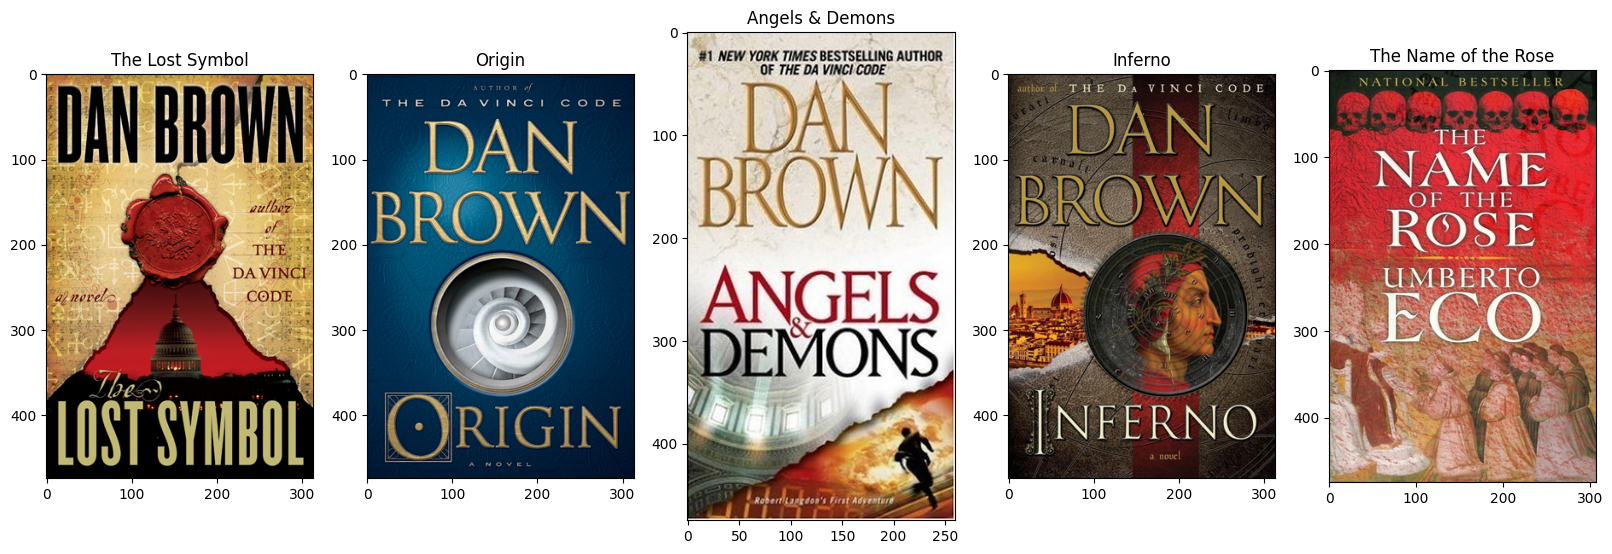

In [ ]:
recommendations("The Da Vinci Code")